# How to solve optimization problem in Pyleecan

This tutorial explains how to use Pyleecan to solve **constrained global optimization** problem.

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Optimization.ipynb).  

The optimization is based on several objects

## Problem definition

### Default Output definition

To define the problem, we first define an output which contains the default simulation. The optimization process will be based on this simulation by varying the design variables.

For this example, we use the simulation defined in the tutorial [How to define a simulation to call FEMM](https://www.pyleecan.org/tuto_Simulation_FEMM.html), but we decrease the precision of the FEMM mesh to speed up the calculations.

In [1]:
# Change of directory to have pyleecan in the path
from os import chdir
chdir('..')

from numpy import ones, pi, array, linspace
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.Output import Output
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Functions.load import load

# Import the machine from a script
IPMSM_A = load('pyleecan/Data/Machine/IPMSM_A.json')
rotor_speed = 2000 # [rpm] 

# Create the Simulation
mySimu = Simu1(name="EM_SIPMSM_AL_001", machine=IPMSM_A)   

# Defining Simulation Input
mySimu.input = InputCurrent()

# time discretization [s]
mySimu.input.time.value= linspace(start=0, stop=60/rotor_speed, num=16, endpoint=False)# 16 timesteps

# Angular discretization along the airgap circonference for flux density calculation
mySimu.input.angle.value = linspace(start = 0, stop = 2*pi, num=2048, endpoint=False) # 2048 steps 

# Rotor speed as a function of time [rpm]
mySimu.input.Nr.value = ones(16) * rotor_speed

# Stator currents as a function of time, each column correspond to one phase [A]
mySimu.input.Is.value = array(
    [
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 5.01400192e-14, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-3.25143725e-14,  1.53286496e+02, -1.53286496e+02],
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 2.11398201e-13, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-3.90282030e-13,  1.53286496e+02, -1.53286496e+02],
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 9.75431176e-14, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-4.33634526e-13,  1.53286496e+02, -1.53286496e+02],
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 4.55310775e-13, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-4.76987023e-13,  1.53286496e+02, -1.53286496e+02]
    ]
)


# Definition of the magnetic simulation (is_mmfr=False => no flux from the magnets)
mySimu.mag = MagFEMM(
    type_BH_stator=0, # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    type_BH_rotor=0,  # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    angle_stator=0,  # Angular position shift of the stator
    file_name = "", # Name of the file to save the FEMM model
    is_symmetry_a=True,   # 0 Compute on the complete machine, 1 compute according to sym_a and is_antiper_a
    sym_a = 4, # Number of symmetry for the angle vector
    is_antiper_a=True, # To add an antiperiodicity to the angle vector
    Kmesh_fineness = 0.2, # Decrease mesh precision
    Kgeo_fineness = 0.2, # Decrease mesh precision
)

# We only use the magnetic part 
mySimu.force = None
mySimu.struct = None 

# Set the default output for the optimization
defaultOutput = Output(simu=mySimu)

### Minimization problem definition

To setup the optimization problem, we define some objective functions using [**OptiObjFunc**](https://www.pyleecan.org/pyleecan.Classes.OptiObjFunc.html). 

Each objective function takes an output object in argument and returns a float to **minimize**. 
We gather the objective functions into a dictionnary.

In [2]:
from pyleecan.Classes.OptiObjFunc import OptiObjFunc
import numpy as np
# Objective functions

def harm1(output):
    """Return the average torque opposite (opposite to be maximized)"""
    N = output.simu.input.time.value.size
    x = output.mag.Tem[:, 0]
    sp = np.fft.rfft(x)
    sp = 2 / N * np.abs(sp)
    return -sp[0] / 2

def harm2(output):
    """Return the first torque harmonic """
    N = output.simu.input.time.value.size
    x = output.mag.Tem[:, 0]
    sp = np.fft.rfft(x)
    sp = 2 / N * np.abs(sp)
    return sp[1]

my_obj = {
    "Opposite average torque (Nm)": OptiObjFunc(
        description="Maximization of the average torque", func=harm1
    ),
    "First torque harmonic (Nm)": OptiObjFunc(
        description="Minimization of the first torque harmonic", func=harm2
    ),
}

### Design variables
We use [**OptiDesignVar**](https://www.pyleecan.org/pyleecan.Classes.OptiDesignVar.html) to define the design variables. 


To define a design variable, we have to specify different attributes:  

- *name* to access to the variable in the output object. This attribute **must begin by "output"**.  
- *type_var* to specify the variable "type":  
    - *interval* for continuous variables 
    - *set* for discrete variables
- *space* to set the variable bound   
- *function* to define the variable for the first generation, the function takes the space in argument and returns the variable value  

We store the design variables in a dictionnary that will be in argument of the problem.

In [3]:
from pyleecan.Classes.OptiDesignVar import OptiDesignVar
import random

# Design variables
my_design_var = {
    "Stator slot opening": OptiDesignVar(
        name="output.simu.machine.stator.slot.W0",
        type_var="interval",
        space=[
            0 * defaultOutput.simu.machine.stator.slot.W2,
            defaultOutput.simu.machine.stator.slot.W2,
        ],
        function=lambda space: random.uniform(*space),
    ),
    "Rotor ext radius": OptiDesignVar(
        name="output.simu.machine.rotor.Rext",
        type_var="set",
        space=[
            0.998 * defaultOutput.simu.machine.rotor.Rext,
            0.999 * defaultOutput.simu.machine.rotor.Rext,
            defaultOutput.simu.machine.rotor.Rext,
            1.001 * defaultOutput.simu.machine.rotor.Rext,
        ],
        function=lambda space: random.choice(space),
    ),
}

### Constraints

The class [**OptiConstraint**](https://www.pyleecan.org/pyleecan.Classes.OptiConstraint.html) enables to define some constraint. For each constraint, we have to define the following attributes:  

- name  
- type_const: type of constraint  
    - "=="  
    - "<="  
    - "<" 
    - ">="
    - ">"
- value: value to compare  
- get_variable: function which takes output in argument and returns the constraint value  

We also store the constraints into a dict.

In [4]:
from pyleecan.Classes.OptiConstraint import OptiConstraint
my_constraint = dict(
    const1 = OptiConstraint(
        name = "const1",
        type_const = "<=",
        value = 2.17,
        get_variable = lambda output: abs(output.mag.Tem_rip),
    )
)

### Evaluation function


We can create our own evaluation function if needed by defining a function which only take an output in argument. 

For this example we keep the default one which calls the `Output.simu.run` method. 

In [5]:
from pyleecan.Classes.OptiProblem import OptiProblem


# Problem creation
my_prob = OptiProblem(
    output=defaultOutput, 
    design_var=my_design_var, 
    obj_func=my_obj,
    constraint = my_constraint,
    eval_func = None # To keep the default evaluation function
)

## Solver

The class [**OptiGenAlgNsga2**](https://www.pyleecan.org/pyleecan.Classes.OptiGenAlgNsga2Deap.html) enables to solve our problem using [NSGA-II](https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf) genetical algorithm. The algorithm takes several parameters:  

|Parameter|Description|Type|Default Value|  
| :-: | :- | :-: | :-: |  
|*problem*|Problem to solve|**OptiProblem**|mandatory|
|*size\_pop*| Population size per generation|**int**|40|  
|*nb\_gen*|Generation number|**int**|100|  
|*p\_cross*|Crossover probability|**float**|0.9|  
|*p\_mutate*|Mutation probability|**float**|0.1|  

  
The `solve` method performs the optimization and returns an [**OutputMultiOpti**](https://www.pyleecan.org/pyleecan.Classes.OutputMultiOpti.html) object which contains the results.

In [6]:
from pyleecan.Classes.OptiGenAlgNsga2Deap import OptiGenAlgNsga2Deap

# Solve problem with NSGA-II
solver = OptiGenAlgNsga2Deap(problem=my_prob, size_pop=16, nb_gen=8, p_mutate=0.5)
res = solver.solve()

18:06:19 Starting optimization... 
	Log file: C:\Users\eomys\AppData\Roaming\Pyleecan\Pyleecan_optimization.log
	Number of generations: 8
	Population size: 16

18:06:19  gen     0: 100%,    0 errors,   0 infeasible.
18:17:43  gen     1: 100%,    0 errors,   0 infeasible.
18:27:20  gen     2: 100%,    0 errors,   0 infeasible.
18:37:33  gen     3: 100%,    0 errors,   0 infeasible.
18:47:03  gen     4: 100%,    0 errors,   0 infeasible.
18:56:59  gen     5: 100%,    0 errors,   0 infeasible.
19:06:52  gen     6: 100%,    0 errors,   0 infeasible.
19:16:51  gen     7: 100%,    0 errors,   0 infeasible.


During the algorithm the object displays some data containing:

- number of errors: failure during the objective function execution
- number of infeasible: number of individual with constraints violations

## Plot results

**OutputMultiOpti** has several methods to display some results:  

- `plot_generation`: to plot individuals for two objective functions  
- `plot_pareto_front`: to plot the pareto front for two objective functions  
- `plot_pareto_front_design_space`: to plot the pareto front in the design space according to two design variables  
- `plot_generation_design_space`: to plot individuals in the design space according to two design variables  


<IPython.core.display.Javascript object>


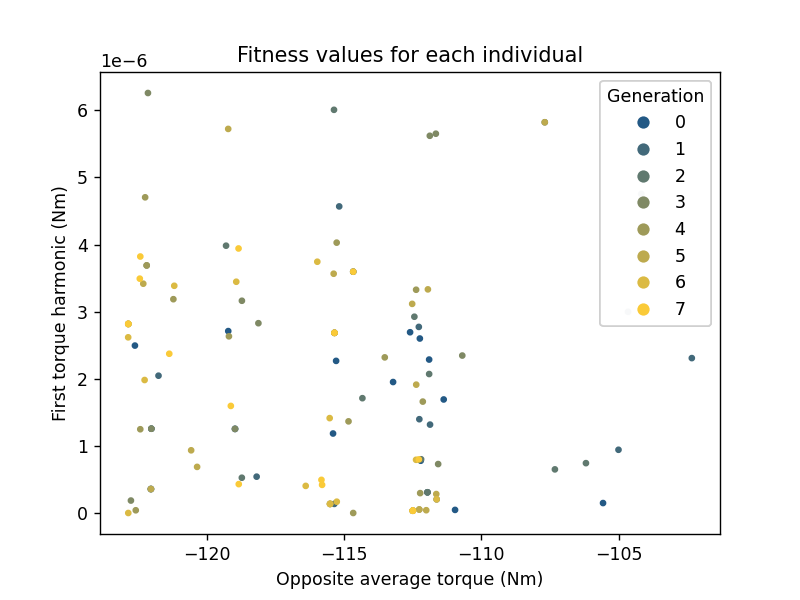

In [7]:
%matplotlib notebook 
res.plot_generation(
    obj1 = "Opposite average torque (Nm)", #label of the first objective function
    obj2 = "First torque harmonic (Nm)", #label of the second objective function
)

<IPython.core.display.Javascript object>


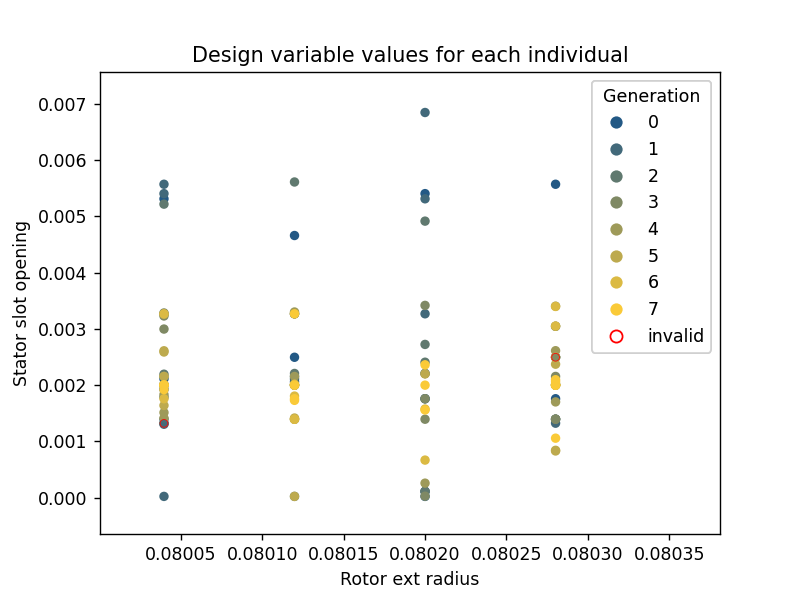

In [8]:
%matplotlib notebook
res.plot_generation_design_space(
    dvar1 = "Rotor ext radius",
    dvar2 = "Stator slot opening"
)

<IPython.core.display.Javascript object>


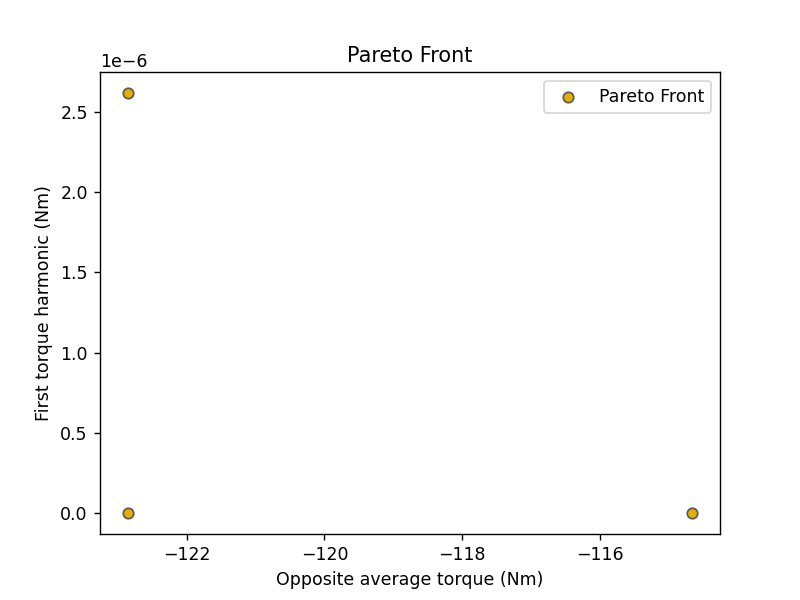

In [9]:
%matplotlib notebook
res.plot_pareto(
    obj1 = "Opposite average torque (Nm)", #label of the first objective function
    obj2 = "First torque harmonic (Nm)", #label of the second objective function
)

<IPython.core.display.Javascript object>


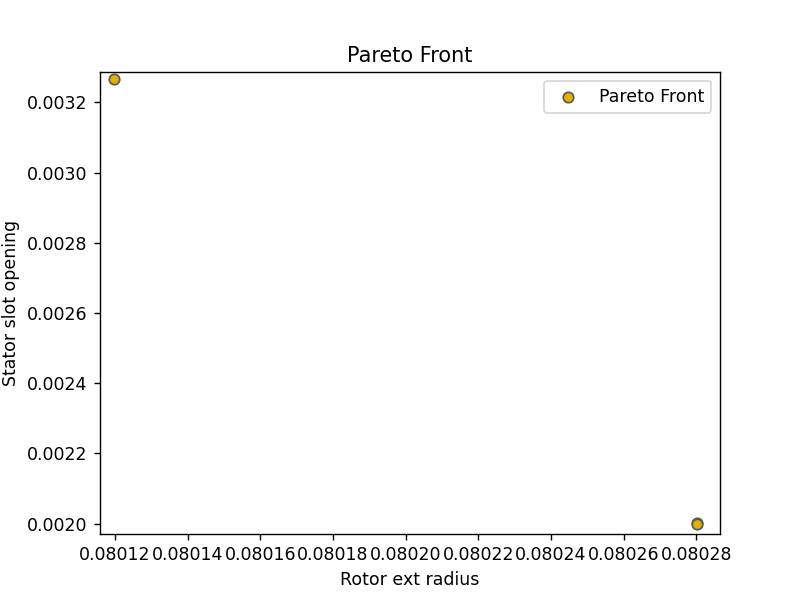

In [10]:
res.plot_pareto_design_space(
    dvar1 = "Rotor ext radius",
    dvar2 = "Stator slot opening"
)